In [62]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import PercentFormatter
from cycler import cycler

# turboSETI imports
from turbo_seti.find_event.find_event import read_dat

%matplotlib inline

ticksize = 6

rcParams['axes.prop_cycle'] = cycler(color=['dodgerblue', 'firebrick', 'seagreen', 'darkmagenta', 'burlywood'])
plt.rcParams.update({'font.size' : 18, 'font.family' : 'serif', 'xtick.major.size' : ticksize, 'ytick.major.size' : ticksize,
                    'xtick.minor.size' : ticksize/2, 'ytick.minor.size' : ticksize/2})

In [63]:
def getPaths():
    
    import subprocess as sp
    
    cmd = 'find /mnt_blc*/datax2/scratch/noahf/ -type d -name *TOI*'
    find = sp.Popen(cmd, stdout=sp.PIPE, shell=True)

    dirs = find.communicate()[0].split(b'\n')

    dirsToReturn = []
    bands = []
    for dir in dirs:
        dd = dir.decode()
        if dd[-7:] != '-copied' and len(dd) != 0:
            dirsToReturn.append(dd)
            bands.append(dd[-1])

    return dirsToReturn, bands

def getGoodNodes(datfiles, band):
    
    datfiles = np.array(datfiles)
    
    if datfiles[0].find('spliced') == -1:
        
        nodes = np.array([os.path.split(file)[1][:5] for file in datfiles])

        if band == 'S' or band == 'L':
            return datfiles
        
        else:
            if band == 'C':
                if len(nodes)/6 == 32:
                    
                    uqnodes = sorted(np.unique(nodes))
                    nodes_to_rm = [uqnodes[7], uqnodes[8], uqnodes[15], uqnodes[16], uqnodes[23], uqnodes[24]]
                    
                    i_to_rm = []
                    for node in nodes_to_rm:
                        whereNodes = np.where(node == nodes)[0]
                        i_to_rm.append(whereNodes)
                    
                    i_to_rm = np.array(i_to_rm).flatten()
                    
                    return np.delete(datfiles, i_to_rm)

                else:
                    raise ValueError(f'There are {len(nodes)} nodes, not 32 as C-Band requires')

            if band == 'X':
                if len(nodes)/6 == 24:
                    
                    uqnodes = sorted(np.unique(nodes))
                    nodes_to_rm = [uqnodes[7], uqnodes[8], uqnodes[15], uqnodes[16]]
                    
                    i_to_rm = []
                    for node in nodes_to_rm:
                        whereNodes = np.where(node == nodes)[0]
                        i_to_rm.append(whereNodes)
                    
                    i_to_rm = np.array(i_to_rm).flatten()
                    return np.delete(datfiles, i_to_rm) 

                else:
                    raise ValueError(f'There are {len(nodes)} nodes, not 32 as C-Band requires')
    else:
        print('This file is already spliced, returning all files')
        return datfiles

paths, bands = getPaths()

In [64]:
overwrite = False

alldatdata = os.path.join(os.getcwd(), 'hit_data.csv')
alleventdata = os.path.join(os.getcwd(), 'event_data.csv')

if not os.path.exists(alldatdata) and not os.path.exists(alleventdata) or overwrite==True:
    
    datdata = []
    eventdata = []

    for dd, band in zip(paths, bands):

        print(f'Reading .dat files from {dd}')

        full_datfiles = glob.glob(dd+'/*.dat')
        eventfiles = glob.glob(dd+'/events-list*.csv')
        
        try:
            datfiles = getGoodNodes(full_datfiles, band)
        except Exception as e:
            print(f'WARNING: The following exception was raised while executing getGoodNodes \n{e}')
        
        try:
            for datfile in datfiles:

                dat = read_dat(datfile)
                dat['Band'] = [band]*len(dat)
                dat['FilePath'] = datfile
                datdata.append(dat)
                
        except Exception as e:
            print(f'WARNING: The following exception was raised \n{e}')

        for eventfile in eventfiles:

            event = pd.read_csv(eventfile)
            event['Band'] = [band]*len(event)
            event['FilePath'] = eventfile
            eventdata.append(event)

    datdf = pd.concat(datdata)
    eventdf = pd.concat(eventdata)

    datdf.to_csv(alldatdata)
    eventdf.to_csv(alleventdata)
    
else:
    print('Output files already exist, reading them now')
    datdf = pd.read_csv(alldatdata)
    eventdf = pd.read_csv(alleventdata)

Output files already exist, reading them now


In [65]:
datmaskL = (datdf.Band=='L') & (datdf.Freq/1000>1.10) & (datdf.Freq/1000<1.90) &  ((datdf.Freq/1000 < 1.20) | (datdf.Freq/1000 > 1.34))
datmaskS = (datdf.Band=='S') & ((datdf.Freq/1000>1.80) & (datdf.Freq/1000<2.80)) & ((datdf.Freq/1000 < 2.30) | (datdf.Freq/1000 > 2.36))
datmaskC = (datdf.Band=='C') & ((datdf.Freq/1000>4.00) & (datdf.Freq/1000<7.80))
datmaskX = (datdf.Band=='X') & ((datdf.Freq/1000>7.80) & (datdf.Freq/1000<11.20))

eventmaskL = (eventdf.Band=='L') & (eventdf.Freq/1000>1.10) & (eventdf.Freq/1000<1.90) &  ((eventdf.Freq/1000 < 1.20) | (eventdf.Freq/1000 > 1.34))
eventmaskS = (eventdf.Band=='S') & ((eventdf.Freq/1000>1.80) & (eventdf.Freq/1000<2.80)) & ((eventdf.Freq/1000 < 2.30) | (eventdf.Freq/1000 > 2.36))
eventmaskC = (eventdf.Band=='C') & ((eventdf.Freq/1000>4.00) & (eventdf.Freq/1000<7.80))
eventmaskX = (eventdf.Band=='X') & ((eventdf.Freq/1000>7.80) & (eventdf.Freq/1000<11.20))

datdf = datdf[datmaskL | datmaskS | datmaskC | datmaskX]
eventdf = eventdf[eventmaskL | eventmaskS | eventmaskC | eventmaskX]

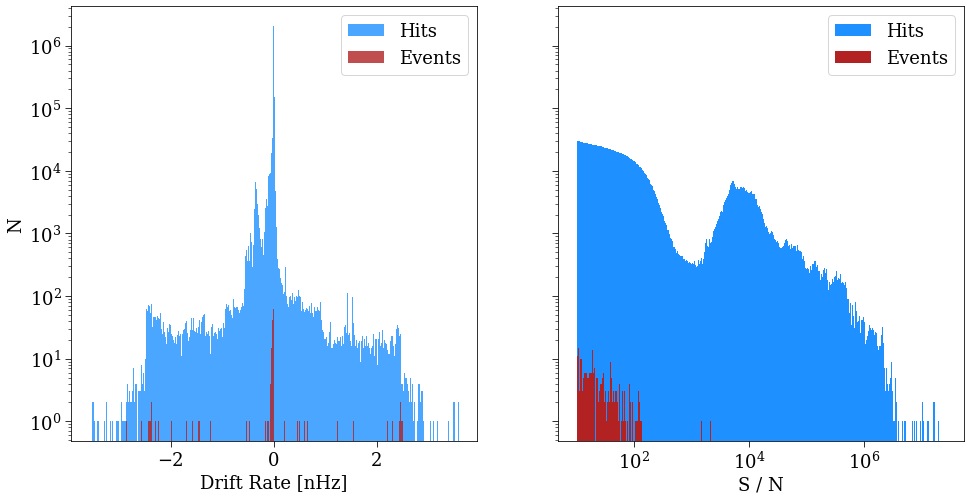

In [66]:
# Drift Rate and SNR plots

def driftRate_SNR_hist(datFileDf, eventFileDf, ax1=None, ax2=None):
    if ax1 == None:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), sharey=True)

    nbins = 500
    aa = 0.8

    ax1.hist(datFileDf.DriftRate/(datFileDf.Freq/1000), bins=nbins, alpha=aa, label='Hits')
    ax1.hist(eventFileDf.DriftRate/(eventFileDf.Freq/1000), bins=nbins, alpha=aa, label='Events')
    ax1.set_yscale('log')
    ax1.set_xlabel('Drift Rate [nHz]')
    ax1.set_ylabel('N')
    ax1.legend()
    
    hist, bins = np.histogram(datFileDf.SNR,bins=nbins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(datFileDf.SNR,bins=logbins)
    ax2.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label='Hits')
    
    hist, bins = np.histogram(eventFileDf.SNR,bins=nbins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(eventFileDf.SNR,bins=logbins)
    ax2.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label='Events')

    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlabel('S / N')
    #ax2.set_ylabel('N')
    ax2.legend();
    
driftRate_SNR_hist(datdf, eventdf)

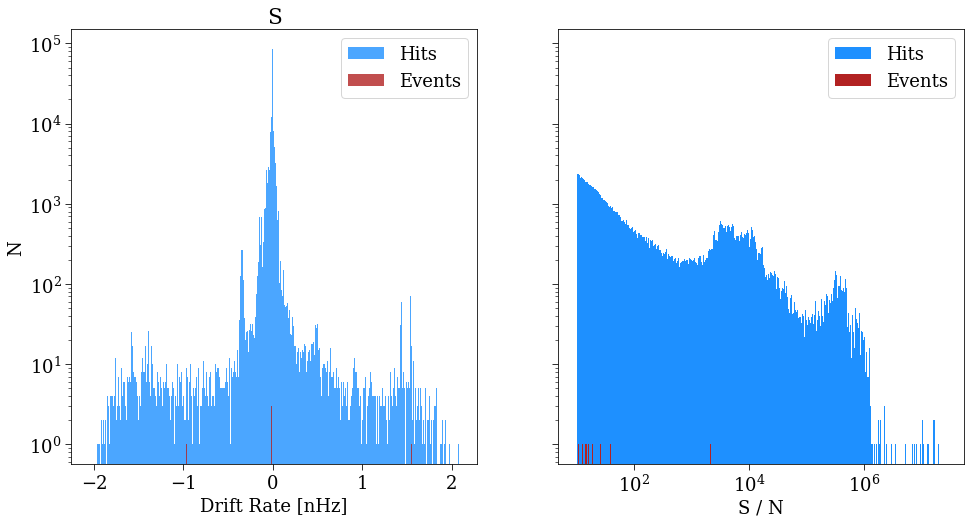

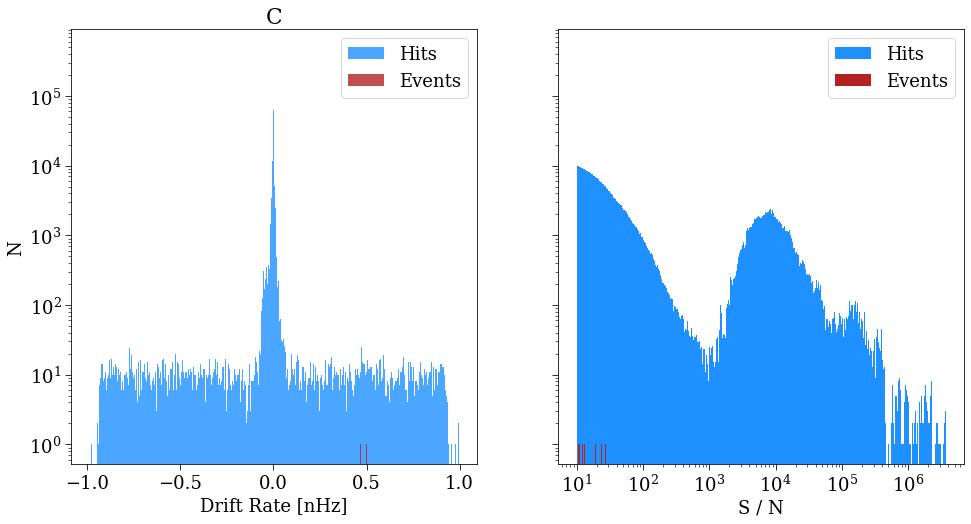

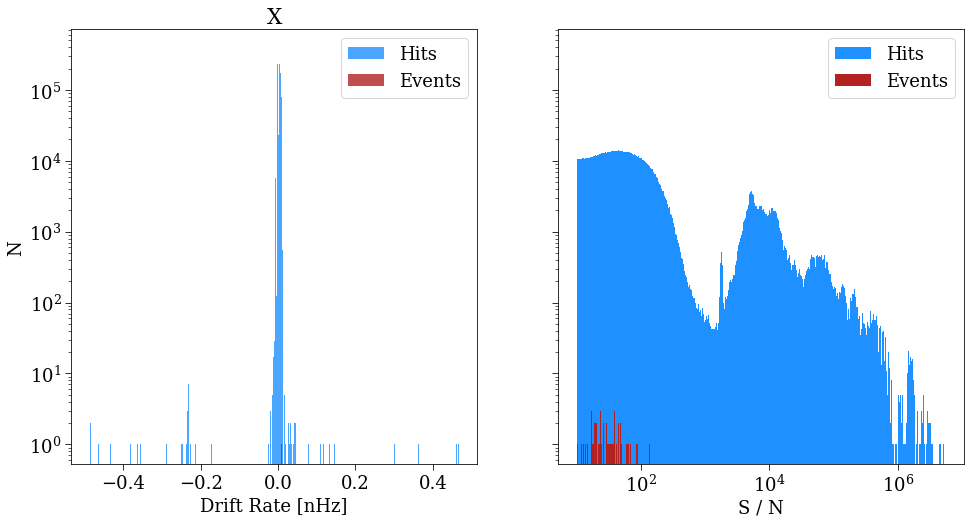

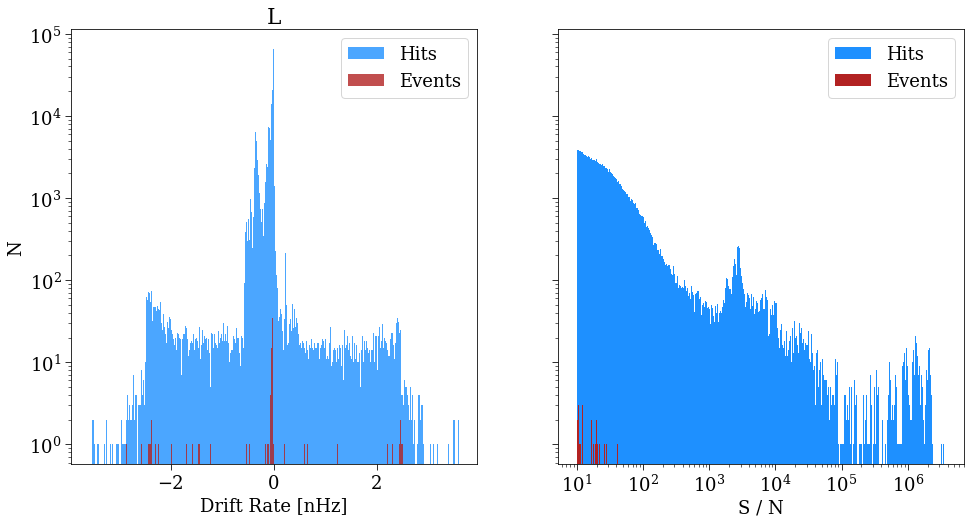

In [67]:
for band in datdf.Band.unique():
    fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)
    driftRate_SNR_hist(datdf[datdf.Band == band], eventdf[eventdf.Band == band], ax1=ax[0], ax2=ax[1])
    ax[0].set_title(band)

['C' 'L' 'S' 'X'] [ 578264  213097  160057 1503241]
['C' 'L' 'S' 'X'] [ 57 172  33 372]


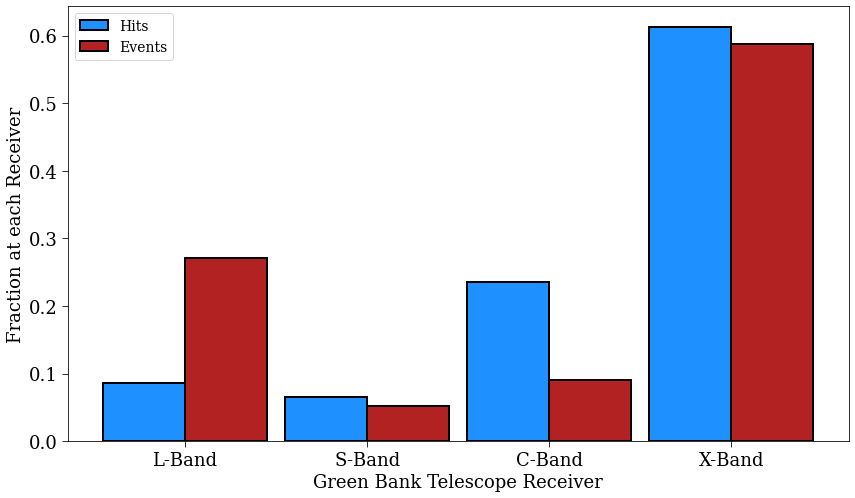

In [68]:
datlabels, datht = np.unique(datdf.Band.to_numpy(), return_counts=True)
eventlabels, eventht = np.unique(eventdf.Band.to_numpy(), return_counts=True)

print(datlabels, datht)
print(eventlabels, eventht)

datht_norm = datht/len(datdf.Band.to_numpy())
eventht_norm = eventht/len(eventdf.Band.to_numpy())

datlabels = np.array(datlabels)
labels = ['L', 'S', 'C', 'X']
dat = []
event = []
for label in labels:
    
    whereLabel = np.where(label == datlabels)[0]
    dat.append(datht_norm[whereLabel][0])
    event.append(eventht_norm[whereLabel][0])

# Histogram of hit breakdown by frequency
fig, ax = plt.subplots(figsize=(14,8))

w = 0.45
i = np.arange(len(datht_norm))

ax.bar(i, dat, w, label='Hits', edgecolor='black', lw=2)
ax.bar(i+w, event, w, label='Events', edgecolor='black', lw=2)

ax.set_xticklabels([label+'-Band' for label in labels])
    
ax.set_ylabel('Fraction at each Receiver')
ax.set_xlabel('Green Bank Telescope Receiver')
ax.set_xticks(i+w/2)
ax.legend(fontsize=14);

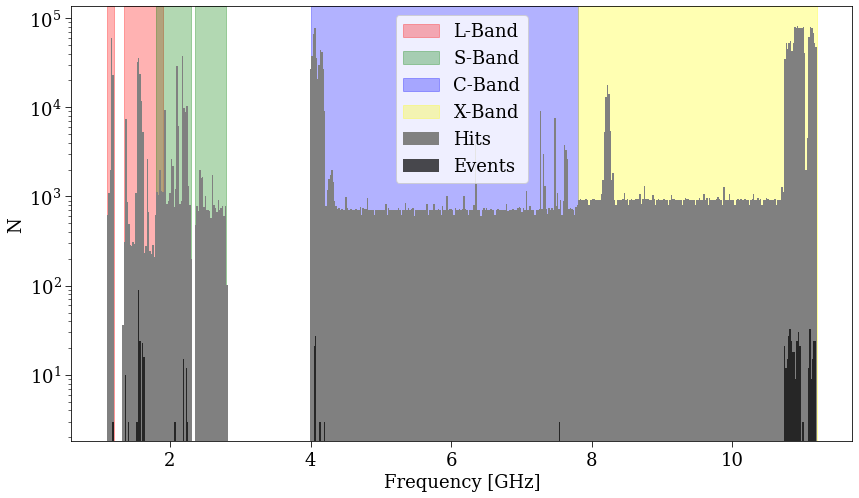

In [69]:
# Histogram of hit breakdown by frequency

aa = 0.3
nbins = 500

fig, ax = plt.subplots(figsize=(14,8))

ax.axvspan(1.10, 1.20, color='red', alpha=aa, label='L-Band')
ax.axvspan(1.34, 1.90, color='red', alpha=aa)
ax.axvspan(1.80, 2.30, color='green', alpha=aa, label='S-Band')
ax.axvspan(2.36, 2.80, color='green', alpha=aa)
ax.axvspan(4.00, 7.80, color='blue', alpha=aa, label='C-Band')
ax.axvspan(7.80, 11.20, color='yellow', alpha=aa, label='X-Band')

ax.hist(datdf.Freq/1000, bins=nbins, label='Hits', color='grey')
ax.hist(eventdf.Freq/1000, bins=nbins, label='Events', alpha=1-aa, color='black')
ax.set_yscale('log')
ax.set_ylabel('N')
ax.set_xlabel('Frequency [GHz]')

_=ax.legend(loc='best')

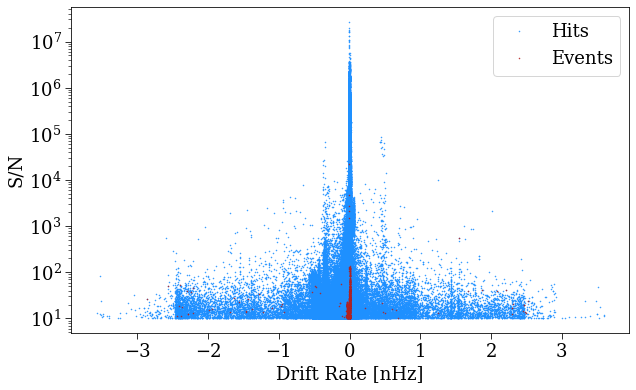

In [70]:
# Plot of SNR vs Drift rate

ms = 1

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(datdf.DriftRate/(datdf.Freq/1000), datdf.SNR, '.', markersize=ms, label='Hits')
ax.plot(eventdf.DriftRate/(eventdf.Freq/1000), eventdf.SNR, '.', markersize=ms, label='Events')
ax.set_yscale('log')

ax.set_xlabel('Drift Rate [nHz]')
ax.set_ylabel('S/N')

ax.legend();

In [71]:
# Check for missing target

def getNCad(target_list, notuq=False):

    ncads = {}
    sumcads = 0
    for ticid in np.unique(target_list):

        whereid = np.where(target_list == ticid)[0]
        
        if notuq:
            ncad = int(len(whereid)/3)
        else:
            ncad = len(whereid)
            
        ncads[ticid] = ncad
        sumcads += ncad
    
    return ncads, sumcads

targetspath = '/home/noahf/BL-TESSsearch/Target-Selection/TESStargets.csv'
targets = pd.read_csv(targetspath)

ticids = np.array([os.path.split(path)[1].split('_')[0].split('-')[1] for path in paths])
bands = np.array([os.path.split(path)[1].split('_')[1] for path in paths])

ncads_og, sumcads_og = getNCad(targets.target_name, notuq=True)
ncads_new, sumcads_now = getNCad(ticids)

disc = None
for key in ncads_og:
    
    lenog = ncads_og[key]
    
    try:
        lennew = ncads_new[key]
        
        if lenog != lennew:
            print(f'Found it! TICID {key} existed but with a different number of cadences')
            print(f'New List has {lennew} while OG list has {lenog}')
            disc = key
        
    except:
        print('Found it! TICID did not exist in new list')
        disc = key

In [72]:
# Get information for transmitter rate vs EIRP plot

import urllib

toiPath = os.path.join(os.getcwd(), 'TESS-toi.csv')

if not os.path.exists(toiPath):

    url = 'https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv'
    urllib.request.urlretrieve(url, toiPath)
    
TESStoi = pd.read_csv(toiPath)

allTOI = TESStoi['TIC ID'].to_numpy()
allTOI_dist = TESStoi['Stellar Distance (pc)'].to_numpy()

uqdatdf = datdf.drop_duplicates(subset='FilePath')
uqdatdf['TIC ID'] = [int(os.path.split(os.path.split(path)[0])[1].split('_')[0].split('-')[1][3:]) for path in uqdatdf.FilePath]

distances = []
for tid in uqdatdf['TIC ID']:
    
    wheretic = np.where(allTOI == tid)[0]    
    distances.append(allTOI_dist[wheretic][0])
    
uqdatdf['Distance (pc)'] = distances

uqbands = uqdatdf.Band.unique()

maxDist = {}
for band in uqbands:
    
    mask = uqdatdf.Band == band

    maxd = max(uqdatdf[mask]['Distance (pc)'].to_numpy())
    maxDist[band] = maxd
    
nbands = {'L':0, 'C':0, 'S':0, 'X':0}

for ticid, band in zip(ticids, bands):
    
    if band == 'L':
        nbands[band] += 1
    elif band == 'C':
        nbands[band] += 1
    elif band == 'S':
        nbands[band] += 1
    elif band == 'X':
        nbands[band] += 1
    else:
        raise Exception('Band unknown')

    
print(maxDist, nbands)

{'S': 560.222, 'C': 935.456, 'X': 746.6460000000001, 'L': 505.33099999999996} {'L': 5, 'C': 21, 'S': 17, 'X': 23}


20   2459029.1697235391
20   2459029.1697235391
20   2459029.1697235391
Name: StartObs, dtype: float64
20   2459029.1912290119
20   2459029.1912290119
20   2459029.1912290119
Name: EndObs, dtype: float64
20   2459029.1561339549
20   2459029.1561339549
20   2459029.1561339549
Name: ingress, dtype: float64
20   2459029.1759256213
20   2459029.1759256213
20   2459029.1759256213
Name: egress, dtype: float64
Area under the histogram is: 66.0


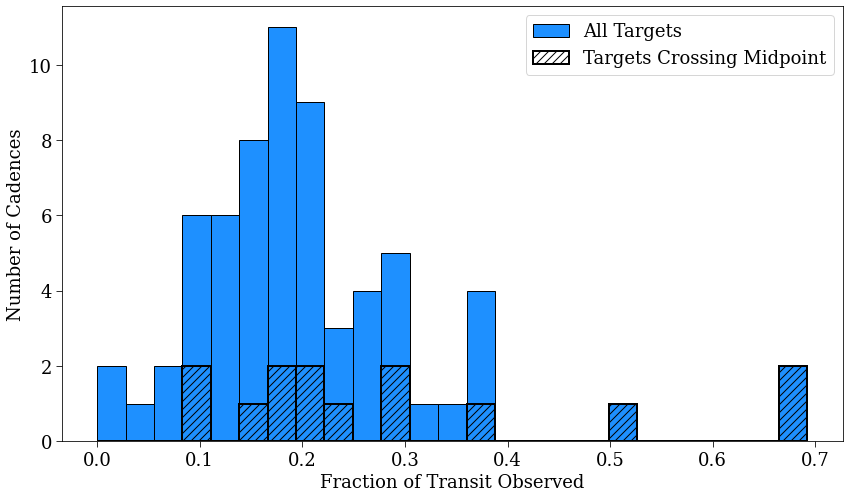

In [73]:
def TransitTimeObs(obsStart, obsEnd, ingress, egress, verbose=False):
    
    transTimeObs = []
    for ii in range(len(obsStart)):
        if obsStart[ii] < ingress[ii] and obsEnd[ii] > egress[ii]: 
            # Observation starts before and ends after transit
            transTimeObs.append(egress[ii] - ingress[ii])
            if verbose:
                print("Outside both ingress and egress")

        elif obsStart[ii] < ingress[ii] and obsEnd[ii] < egress[ii]:
            # Obs starts before transit starts and ends before transit ends
            transTimeObs.append(obsEnd[ii] - ingress[ii])
            if verbose:
                print('Obs starts before transit starts and ends before transit ends')

        elif obsStart[ii] > ingress[ii] and obsEnd[ii] > egress[ii]:
            # Obs starts after transit starts and ends after transit ends
            transTimeObs.append(egress[ii] - obsStart[ii])
            if verbose:
                print('Obs starts after transit starts and ends after transit ends')

        else:
            # 'Observation is entirely during transit'
            transTimeObs.append(obsEnd[ii] - obsStart[ii])
            #print(obsEnd[ii] - obsStart[ii])
            if verbose:
                print('Observation is entirely during transit')
    
    fracTransit = np.array(transTimeObs)/(egress-ingress)
            
    return fracTransit

def cleanupFracs(fracTransit):
    
    num = 0
    fracsdict = {0:[fracTransit[0]]}
    for ii in range(1,len(fracTransit)):

        if fracTransit[ii-1] == fracTransit[ii]:
            fracsdict[num].append(fracTransit[ii])

        else:
            num += 1
            fracsdict[num] = [fracTransit[ii]]

    fracs = []
    for key in fracsdict:
        if len(fracsdict[key]) == 3:
            fracs.append(fracsdict[key][0])
        else:
            for i in range(int(np.floor(len(fracsdict[key])/3))):
                fracs.append(fracsdict[key][0])
                
    return fracs
        
transitTimes = pd.read_csv(os.path.join(os.getenv('HOME'), 'BL-TESSsearch', 'analysis', 'TransitTimes.csv'))
tesstargs = pd.read_csv(os.path.join(os.getenv('HOME'), 'BL-TESSsearch', 'Target-Selection', 'TESStargets.csv'))

maskSame = []
for tid, sess in zip(tesstargs['TIC ID'], tesstargs['session']):
    
    whereSame = np.where((transitTimes['TIC ID'].to_numpy() == tid) & (transitTimes.session.to_numpy() == sess))[0]
    if len(whereSame) != 0:
        maskSame.append(whereSame)
    else:
        whereTID = np.where(tesstargs == tid)[0]
        
tt = transitTimes.iloc[np.hstack(np.array(maskSame))]
pd.options.display.float_format = '{:.10f}'.format
print(tt[tt.target_name == 'TIC241076290'].StartObs)
print(tt[tt.target_name == 'TIC241076290'].EndObs)
print(tt[tt.target_name == 'TIC241076290'].ingress)
print(tt[tt.target_name == 'TIC241076290'].egress)

# Get transit observation fractions for all targets
fracTransit = TransitTimeObs(tt.StartObs.to_numpy(), tt.EndObs.to_numpy(), tt.ingress.to_numpy(), tt.egress.to_numpy())
fracs = cleanupFracs(fracTransit)

# Get transit observation fractions for only targets that cross the transit midpoint
tt['midpoint'] = tt.ingress + (tt.egress-tt.ingress)/2
crossMid = np.where((tt.StartObs.to_numpy() < tt.midpoint.to_numpy()) & (tt.EndObs.to_numpy() > tt.midpoint.to_numpy()))[0]
fracTransitMod = TransitTimeObs(tt.StartObs.to_numpy()[crossMid], tt.EndObs.to_numpy()[crossMid], 
                                tt.ingress.to_numpy()[crossMid], tt.egress.to_numpy()[crossMid])
fracsMid = cleanupFracs(fracTransitMod)

nbins = 25
fig, ax = plt.subplots(figsize=(14,8))
bins = ax.hist(fracs, range=(0,max(fracs)), bins=nbins, label='All Targets', edgecolor='k')
binsMid = ax.hist(fracsMid, range=(0,max(fracs)), bins=nbins, hatch='///', fill=False, edgecolor='k', lw=2, label='Targets Crossing Midpoint')

ax.set_xlabel('Fraction of Transit Observed')
ax.set_ylabel('Number of Cadences')
ax.legend()
plt.savefig('Ncad_vs_fracObs.png', transparent=False)
print(f'Area under the histogram is: {sum(bins[0])}')

In [74]:
# Check for discrepancies between TESS Target Files

def getNCad2(target_list):
    
    ncads = {}
    sumcads = 0
    for ticid in np.unique(target_list):

        whereid = np.where(target_list == ticid)[0]
        
        if len(whereid) >= 3:
            ncad = int(len(whereid)/3)
        else:
            ncad = len(whereid)
            
        ncads[ticid] = ncad
        sumcads += ncad
    
    return ncads, sumcads

targetspath = os.path.join(os.getenv('HOME'), 'BL-TESSsearch', 'Target-Selection', 'TESStargets.csv')
targets = pd.read_csv(targetspath)

ncads_og, sumcads_old = getNCad2(targets.target_name.to_numpy())
ncads_new, sumcads_new = getNCad2('TIC' + tt['TIC ID'].astype(str).to_numpy())

disc = []
for key in ncads_og:
    
    try:
        lennew = ncads_new[key]
        lenog = ncads_og[key]
        
        if lenog != lennew:
            print(f'Found it! {key} existed but with a different number of cadences')
            print(f'New List has {lennew} while OG list has {lenog}')
            disc.append(key)
        
    except:
        print(f'Found it! {key} did not exist in new list')
        disc.append(key)

In [75]:
# Drake Figure of Merit Calculation

def DFOM(df, omega, S, n=1):
    '''
    Drake Figure of Merit Equation
    df : frequency range
    omega : Area of sky surveyed
    S : minimum detectable flux average across all observing frequencies
    n : number of observations at the band
    
    From Gajjar et al. Equation 10 (https://arxiv.org/pdf/2104.14148.pdf)
    '''
    
    dfom = n*(df*omega) / (S**(3/2))
    return dfom

def SolidAngle(d):
    '''
    Calculate the steradian of some beam with an FWHM of d
    '''
    
    return 2*np.pi*(1-np.cos(d/2))
    
df = np.array([1.9-1.1, 2.8-1.8, 7.8-4, 11.2-7.8]) #* 10**9
S = np.array([5.304, 5.032, 7.310, 10.470])*10**-26 #Jy # From Traas et al
FWHM = np.array([8.8, 6.2, 2.5, 1.4]) * (1/60) * (1/360) #* 2*np.pi # Put each angle in degrees
omega = SolidAngle(FWHM)

dfom = 0
for ii, key in enumerate(nbands):
    
    n = nbands[key]
    dfom += DFOM(df[ii], omega[ii], S[ii], n)
    
dfom

2.0507806241135517e+32

In [76]:
# Calculate Transmitter Limit with a Poisson Confidence Interval

nevents = 3.689 # Table 1 https://ui.adsabs.harvard.edu/abs/1986ApJ...303..336G/abstract

transmitter_limits = {}
for key in nbands:
    
    transmitter_limits[key] = (nevents/nbands[key])*100

transmitter_limits

{'L': 73.78, 'C': 17.566666666666666, 'S': 21.7, 'X': 16.03913043478261}

I also calculated the Binomial Confidence interval using https://statpages.info/confint.html and got


L : 52.18%

C : 16.11%

S : 19.51%

X : 14.82%

In [77]:
nbands

{'L': 5, 'C': 21, 'S': 17, 'X': 23}